# Chicago Bike Infrastructure Project
<h3>Capstone Project for Data Analytics Certificate<br>
University of Texas<br><br>
Samantha Goodman
<br>December 2021</h3><br>
This notebook is part 5 of a 5 part series.<br>
       1 - Bike Shops from FourSquare API<br>
    2 - Bike Infrastructure<br>
        3 - Background information about neighborhoods<br>
        4 - Analysis<br>
        <b>5 - Model Building and Predictions<br><br></b>
    Questions this project aims to answer:<br>
    <ul><li>Which community areas (neighborhoods) have the most bike infrastructure, and which have the least?</li>
<li>Are there areas that show an unmet demand for bike infrastructure (higher rates of Divvy trips, but lower rates of bike lanes and repair shops)?</li>
<li>Can I predict bike infrastructure levels based on demographic or community health data?


In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#estimators
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.cluster import KMeans 

#model metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

#cross validation
from sklearn.model_selection import train_test_split

# Question: Can I predict bike infrastructure levels based on demographic or community health data? 

<H3>Step 1: Gather all data, including demographic and bike infrastructure data

In [2]:
# Import bike infrastructure scores CSV to dataframe
bike_scores = pd.read_csv('infrastructure_scores.csv', index_col=0)

In [3]:
bike_scores.head()

,community,bike_lanes_percent,bike_shop_density,bike_rack_density,divvy_station_density,score
0,LOOP,0.741507,0.376449,1.000000,1.000000,100.000000
1,UPTOWN,0.914301,0.401938,0.244816,0.249133,98.818024
2,OAKLAND,1.000000,0.000000,0.027231,0.000000,96.614673
3,LAKE VIEW,0.632913,1.000000,0.358060,0.517999,83.521269
4,ROGERS PARK,0.713717,0.510427,0.213853,0.384172,82.062811


In [4]:
# Import neighborhood data from Notebook 3
df = pd.read_csv('neighborhood_data.csv', index_col=0)

In [5]:
df.head()

,comm_num,community,area_kmsq,length_streets_m,percent of housing crowded,percent households below poverty,percent aged 16+ unemployed,percent aged 25+ without high school diploma,percent aged under 18 or over 64,per capita income,...,hisp,black,asian,other,pop,percent_white,percent_hisp,percent_black,percent_asian,percent_other
0,1,ROGERS PARK,51.259902,57712.379599,7.7,23.6,8.7,18.2,27.5,23939,...,10887.0,15187.0,2695.0,2349.0,79832.0,30.510322,13.637389,19.023700,3.375839,2.942429
1,2,WEST RIDGE,98.429095,121335.202892,7.8,17.2,8.8,20.8,38.5,23040,...,14835.0,9086.0,18650.0,4059.0,110302.0,28.862577,13.449439,8.237385,16.908125,3.679897
2,3,UPTOWN,65.095643,63769.090382,3.8,24.0,8.9,11.8,22.2,35787,...,8609.0,10476.0,6207.0,1713.0,90953.0,35.154420,9.465328,11.518037,6.824404,1.883390
3,4,LINCOLN SQUARE,71.352328,76974.128441,3.4,10.9,8.2,13.4,25.5,37524,...,7611.0,1470.0,3820.0,2037.0,69268.0,39.217243,10.987758,2.122192,5.514812,2.940752
4,5,NORTH CENTER,57.054168,73743.375859,0.3,7.5,5.2,4.5,26.2,57123,...,4070.0,750.0,1737.0,1357.0,63172.0,43.736149,6.442728,1.187235,2.749636,2.148104


In [6]:
# Merge bike score data with neighborhood background data

df = df.merge(bike_scores.loc[:,['score', 'community']], how='left', on='community')

In [7]:
df.head()

,comm_num,community,area_kmsq,length_streets_m,percent of housing crowded,percent households below poverty,percent aged 16+ unemployed,percent aged 25+ without high school diploma,percent aged under 18 or over 64,per capita income,...,black,asian,other,pop,percent_white,percent_hisp,percent_black,percent_asian,percent_other,score
0,1,ROGERS PARK,51.259902,57712.379599,7.7,23.6,8.7,18.2,27.5,23939,...,15187.0,2695.0,2349.0,79832.0,30.510322,13.637389,19.023700,3.375839,2.942429,82.062811
1,2,WEST RIDGE,98.429095,121335.202892,7.8,17.2,8.8,20.8,38.5,23040,...,9086.0,18650.0,4059.0,110302.0,28.862577,13.449439,8.237385,16.908125,3.679897,28.518248
2,3,UPTOWN,65.095643,63769.090382,3.8,24.0,8.9,11.8,22.2,35787,...,10476.0,6207.0,1713.0,90953.0,35.154420,9.465328,11.518037,6.824404,1.883390,98.818024
3,4,LINCOLN SQUARE,71.352328,76974.128441,3.4,10.9,8.2,13.4,25.5,37524,...,1470.0,3820.0,2037.0,69268.0,39.217243,10.987758,2.122192,5.514812,2.940752,51.188618
4,5,NORTH CENTER,57.054168,73743.375859,0.3,7.5,5.2,4.5,26.2,57123,...,750.0,1737.0,1357.0,63172.0,43.736149,6.442728,1.187235,2.749636,2.148104,65.510778


In [8]:
df.columns = df.columns.str.replace('score', 'bike_infrastructure_score')

In [9]:
# Check for N/As 
df.isnull().sum().sum()

1

In [10]:
df.tail()

,comm_num,community,area_kmsq,length_streets_m,percent of housing crowded,percent households below poverty,percent aged 16+ unemployed,percent aged 25+ without high school diploma,percent aged under 18 or over 64,per capita income,...,black,asian,other,pop,percent_white,percent_hisp,percent_black,percent_asian,percent_other,bike_infrastructure_score
72,73,WASHINGTON HEIGHTS,79.635753,112853.904472,1.1,16.9,20.8,13.7,42.6,19713,...,25698.0,43.0,336.0,27102.0,1.328315,1.125378,94.819571,0.158660,1.239761,25.096447
73,74,MOUNT GREENWOOD,75.584290,70760.271688,1.0,3.4,8.7,4.3,36.8,34381,...,678.0,354.0,249.0,35089.0,45.310496,5.728291,1.932229,1.008863,0.709624,2.493343
74,75,MORGAN PARK,91.877341,111872.626252,0.8,13.2,15.0,10.8,40.3,27149,...,13216.0,61.0,570.0,27388.0,23.075800,3.289762,48.254710,0.222725,2.081203,8.994447
75,76,OHARE,371.835608,205033.967690,3.6,15.4,7.1,10.9,30.3,25828,...,256.0,1582.0,253.0,22678.0,42.345004,6.089602,1.128847,6.975924,1.115619,NaN
76,77,EDGEWATER,48.449991,58617.599531,4.1,18.2,9.2,9.7,23.8,33385,...,7096.0,7169.0,2081.0,90279.0,36.143511,9.606885,7.860078,7.940939,2.305076,74.635513


In [11]:
# Remove OHare community area, since it is not really a neighbhorhood where people live
df.drop(75, inplace=True)
df.reset_index(drop=True, inplace=True)

So hardship index is a score calculated by the City of Chicago, see
https://data.cityofchicago.org/Health-Human-Services/hardship-index/792q-4jtu

# Linear Regression to Predict Infrastructure Score

In [12]:
#features
X = df.copy()
X.drop(columns=['area_kmsq', 'length_streets_m', 'bike_infrastructure_score', 'community', 'white', 'black', 'hisp', 'asian', 'other', 'geoid'], inplace = True)
print('Summary of feature sample')
X.head()

Summary of feature sample


,comm_num,percent of housing crowded,percent households below poverty,percent aged 16+ unemployed,percent aged 25+ without high school diploma,percent aged under 18 or over 64,per capita income,hardship index,med_age,pop,percent_white,percent_hisp,percent_black,percent_asian,percent_other
0,1,7.7,23.6,8.7,18.2,27.5,23939,39.0,34.0,79832.0,30.510322,13.637389,19.023700,3.375839,2.942429
1,2,7.8,17.2,8.8,20.8,38.5,23040,46.0,35.5,110302.0,28.862577,13.449439,8.237385,16.908125,3.679897
2,3,3.8,24.0,8.9,11.8,22.2,35787,20.0,36.5,90953.0,35.154420,9.465328,11.518037,6.824404,1.883390
3,4,3.4,10.9,8.2,13.4,25.5,37524,17.0,35.3,69268.0,39.217243,10.987758,2.122192,5.514812,2.940752
4,5,0.3,7.5,5.2,4.5,26.2,57123,6.0,34.6,63172.0,43.736149,6.442728,1.187235,2.749636,2.148104


In [13]:
#dependent variable
y = df['bike_infrastructure_score']

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 15 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   comm_num                                      76 non-null     int64  
 1   percent of housing crowded                    76 non-null     float64
 2   percent households below poverty              76 non-null     float64
 3   percent aged 16+ unemployed                   76 non-null     float64
 4   percent aged 25+ without high school diploma  76 non-null     float64
 5   percent aged under 18 or over 64              76 non-null     float64
 6   per capita income                             76 non-null     int64  
 7   hardship index                                76 non-null     float64
 8   med_age                                       76 non-null     float64
 9   pop                                           76 non-null     float

In [15]:
model = LinearRegression(n_jobs=10)

In [16]:
print(cross_val_score(model, X, y, cv=3)) 

[ 0.31274278  0.31102882 -2.75081051]


Cross Val Score was 0.31, so not so great

In [17]:
algosClass = []
algosClass.append(('Random Forest Regressor',RandomForestRegressor()))
algosClass.append(('Linear Regression',LinearRegression()))
algosClass.append(('Support Vector Regression',SVR()))

#regression
results = []
names = []

for name, model in algosClass:
    result = cross_val_score(model, X,y, cv=3, scoring='r2')
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest Regressor 0.022957010175955528
Linear Regression -0.7090129663743959
Support Vector Regression -0.5308220628643705


None of the models for linear regression scored high enough to move forward with them.

In [18]:
# A correlation matrix of the dataset
corr_mat = df.corr()
print(corr_mat)

                                              comm_num  area_kmsq  \
comm_num                                      1.000000   0.084196   
area_kmsq                                     0.084196   1.000000   
length_streets_m                             -0.049749   0.746423   
percent of housing crowded                    0.010439   0.031901   
percent households below poverty              0.162911  -0.054543   
percent aged 16+ unemployed                   0.411190  -0.048732   
percent aged 25+ without high school diploma  0.198048   0.044389   
percent aged under 18 or over 64              0.454406   0.046216   
per capita income                            -0.406201  -0.060685   
hardship index                                0.342533   0.011832   
geoid                                         1.000000   0.084196   
med_age                                       0.089517  -0.120894   
white                                        -0.537542   0.096526   
hisp                              

Correlation matrix yielded some insteresting results.<br>
For Bike Infrastructure Score the two highest results were:<br>
percent aged under 18 or over 64:  -0.708703<br>
per capita income: 0.569037


In [19]:
df.head()

,comm_num,community,area_kmsq,length_streets_m,percent of housing crowded,percent households below poverty,percent aged 16+ unemployed,percent aged 25+ without high school diploma,percent aged under 18 or over 64,per capita income,...,black,asian,other,pop,percent_white,percent_hisp,percent_black,percent_asian,percent_other,bike_infrastructure_score
0,1,ROGERS PARK,51.259902,57712.379599,7.7,23.6,8.7,18.2,27.5,23939,...,15187.0,2695.0,2349.0,79832.0,30.510322,13.637389,19.023700,3.375839,2.942429,82.062811
1,2,WEST RIDGE,98.429095,121335.202892,7.8,17.2,8.8,20.8,38.5,23040,...,9086.0,18650.0,4059.0,110302.0,28.862577,13.449439,8.237385,16.908125,3.679897,28.518248
2,3,UPTOWN,65.095643,63769.090382,3.8,24.0,8.9,11.8,22.2,35787,...,10476.0,6207.0,1713.0,90953.0,35.154420,9.465328,11.518037,6.824404,1.883390,98.818024
3,4,LINCOLN SQUARE,71.352328,76974.128441,3.4,10.9,8.2,13.4,25.5,37524,...,1470.0,3820.0,2037.0,69268.0,39.217243,10.987758,2.122192,5.514812,2.940752,51.188618
4,5,NORTH CENTER,57.054168,73743.375859,0.3,7.5,5.2,4.5,26.2,57123,...,750.0,1737.0,1357.0,63172.0,43.736149,6.442728,1.187235,2.749636,2.148104,65.510778


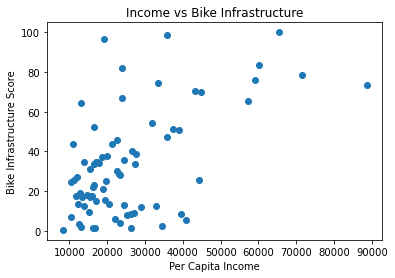

In [21]:
#Invesigating income vs bike infrastructure scor
x = df['per capita income ']
y = df['bike_infrastructure_score']

plt.scatter(x,y, marker='o')
plt.xlabel("Per Capita Income")
plt.ylabel("Bike Infrastructure Score")
plt.title("Income vs Bike Infrastructure")
plt.show()

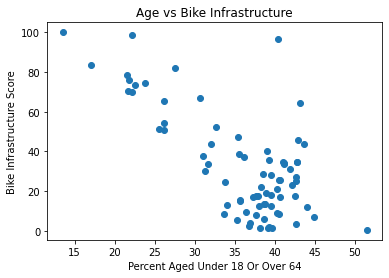

In [39]:
#Invesigating percent under 18 or over 64 vs bike infrastructure scor
x = df['percent aged under 18 or over 64']
y = df['bike_infrastructure_score']

plt.scatter(x,y, marker='o')
plt.xlabel("Percent Aged Under 18 Or Over 64")
plt.ylabel("Bike Infrastructure Score")
plt.title("Age vs Bike Infrastructure")
plt.show()

# K Means Clustering

Since linear regression didn't yield good results, I tried to cluster the community areas using K Means to see what clusters the algorithm provided and if it could group them in a way that is useful.

In [26]:
df = df.drop(['community', 'geoid', 'white', 'hisp', 'black', 'asian', 'other', 'area_kmsq', 'length_streets_m'], axis=1)

In [27]:
from sklearn.preprocessing import StandardScaler
X = df.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[ 0.74984334,  0.15208791, -0.90630176, ..., -0.13419446,
         1.5520824 ,  1.88512367],
       [ 0.77701935, -0.40411931, -0.89293759, ...,  1.41973565,
         2.35420173, -0.17196867],
       [-0.31002106,  0.18685087, -0.87957342, ...,  0.26180873,
         0.40020112,  2.52883085],
       ...,
       [-1.07094935, -1.60344115, -0.90630176, ..., -0.40599743,
        -0.8764654 , -1.1718019 ],
       [-1.12530137, -0.75174883, -0.06435903, ..., -0.49627067,
         0.61535588, -0.92204038],
       [-0.22849303, -0.31721194, -0.83948091, ...,  0.39002189,
         0.85885514,  1.59977933]])

In [28]:
clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[0 0 0 0 0 2 2 2 3 0 1 1 3 0 0 0 0 3 0 3 1 0 1 2 0 3 3 0 1 0 1 0 1 3 3 3 3
 3 3 3 1 3 1 1 3 3 3 3 1 3 3 3 3 3 3 1 3 1 3 1 1 3 1 1 1 1 3 3 3 1 1 1 3 1
 3 0]


In [40]:
df["Clus_km"] = labels

In [41]:
df.groupby('Clus_km').mean()

,comm_num,percent of housing crowded,percent households below poverty,percent aged 16+ unemployed,percent aged 25+ without high school diploma,percent aged under 18 or over 64,per capita income,hardship index,med_age,pop,percent_white,percent_hisp,percent_black,percent_asian,percent_other,bike_infrastructure_score
Clus_km,,,,,,,,,,,,,,,,
0,18.823529,5.694118,17.141176,10.482353,19.100000,29.723529,30988.588235,35.176471,35.705882,82574.705882,29.689231,22.745790,10.127632,5.800708,1.947407,46.786467
1,48.565217,5.573913,19.434783,14.491304,22.226087,36.773913,23643.956522,50.478261,36.034783,42588.000000,18.163403,29.657102,29.028049,3.690287,1.297756,23.041696
2,11.250000,1.525000,12.825000,5.850000,5.400000,20.700000,65869.000000,4.500000,32.375000,150342.500000,41.953405,6.286440,3.487537,4.699110,1.620102,76.544563
3,45.156250,4.512500,27.215625,20.053125,21.809375,40.259375,19013.843750,62.843750,37.106250,18831.218750,9.460588,17.545063,57.632725,4.471688,1.429348,27.377249


In [31]:
X.shape

(76, 15)

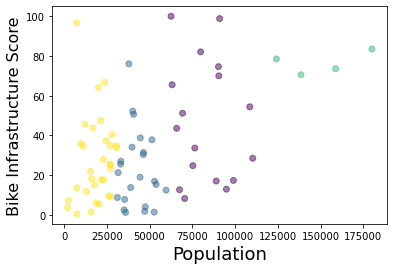

In [32]:
plt.scatter(X[:, 8], X[:, 14], marker='o', c=labels.astype(np.float), alpha=0.5)
plt.xlabel('Population', fontsize=18)
plt.ylabel('Bike Infrastructure Score', fontsize=16)

plt.show()

In [34]:
df.columns

Index(['comm_num', 'percent of housing crowded',
       'percent households below poverty', 'percent aged 16+ unemployed',
       'percent aged 25+ without high school diploma',
       'percent aged under 18 or over 64', 'per capita income ',
       'hardship index', 'med_age', 'pop', 'percent_white', 'percent_hisp',
       'percent_black', 'percent_asian', 'percent_other',
       'bike_infrastructure_score', 'Clus_km'],
      dtype='object')

In [36]:
clustered_neighborhoods = df.loc[:,['comm_num', 'Clus_km']]

In [37]:
clustered_neighborhoods.tail()

,comm_num,Clus_km
71,72,1
72,73,3
73,74,1
74,75,3
75,77,0


In [38]:
# Save clustered neighborhood data, in case it is useful
# Save dataframe to CSV for use in analysis notebook
clustered_neighborhoods.to_csv('neighborhood_clusters.csv')